In [18]:
# delay checkerboard descrimination task: training failed
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.dlpfc.basic2 import Basic2

from psychrnn.backend.dlpfc.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checkerDelay import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [19]:
experiment = 'interactive'
name = 'basic'
dt = 10
tau = 50
T = 6000
N_batch = 50
N_rec = 100
N_in = 2
N_out = 2


# Generate a batch of trials

In [20]:
task = Checkerboard2AFC(N_in = N_in, N_out = N_out, dt=dt, tau=tau, T=T, N_batch=N_batch, 
                        noise = 0.2, accumulation_mask = 300, wait = 0.2)

In [21]:
params = task.get_task_params()
params

{'N_batch': 50,
 'N_in': 2,
 'N_out': 2,
 'dt': 10,
 'tau': 50,
 'T': 6000,
 'alpha': 0.2,
 'N_steps': 600,
 'coherence': [-0.9, 0.9],
 'noise': 0.2,
 'checkerDur': 2000,
 'checker_onset': [125, 126],
 'delay': [400, 600],
 'accumulation_mask': 300,
 'decision_threshold': 0.7,
 'post_decision_baseline': 0.2,
 'wait': 0.2,
 'hi': 1,
 'lo': 0}

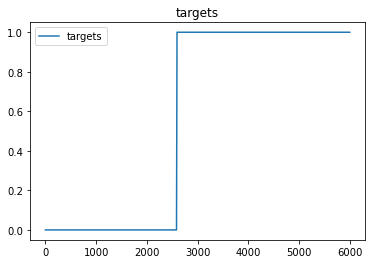

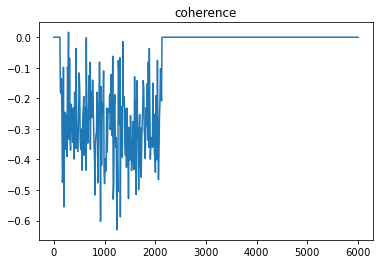

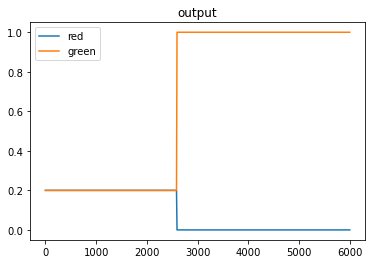

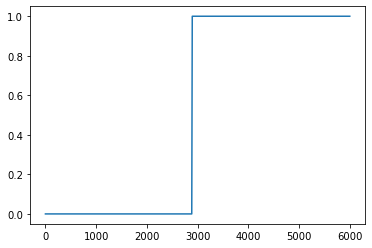

{'coherence': -0.2834892131691097, 'noise': 0.2, 'accumulation_mask': 300, 'checkerDur': 2000, 'checker_onset': 125, 'delay': 457}


In [22]:
#### must check RT and time step 

[x, y, mask, allParams] = task.get_trial_batch()

trialNum = 11
# x[0]: targets.: 0 represents targets are off; 1 represents on
# x[1]: color: -1: total green 1: total red
trialIn = x[trialNum,:,:]
trialOut = y[trialNum,:,:]
trialMask = mask[trialNum,:,:]
time = np.linspace(0, task.T, int(task.T/task.dt))
# plot target configuration (-1: red 1: green)
plt.figure()
plt.plot(time, trialIn[:,0], label = 'targets')
plt.legend()
plt.title("targets")

# plot input coherence (positive: red negative: green)
plt.figure()
plt.plot(time, trialIn[:,1])
plt.title("coherence")

# plot output to the model 
# y[0]: red evidence
# y[1]: green evidence
plt.figure()
plt.plot(time, trialOut[:,0], label = 'red')
plt.plot(time, trialOut[:,1], label = 'green')
plt.legend()
plt.title("output")

# # plot trial masks
plt.figure()
plt.plot(time, trialMask[:,0])

plt.show()

# side: green side
# green_side = 0: left is green; x[0] = 1; x[1] = -1
# green_side = 1: right is green; x[0] = -1; x[1] = 1

print(allParams[trialNum])

# Set Network params

In [23]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.2

network_params["transfer_function"] = tf.nn.tanh
# network_params["output_transfer_function"] = tf.nn.sigmoid
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07

# add a dale's ratio 
network_params['dale_ratio'] = .8



In [24]:
try:
    model.destruct()
except:
    pass

model = Basic2(network_params)

model.decision_threshold = network_params.get("decision_threshold", np.inf)

In [25]:
# check model
vars(model)

# a = model.get_weights()
# a.keys()



{'params': {'N_batch': 50,
  'N_in': 2,
  'N_out': 2,
  'dt': 10,
  'tau': 50,
  'T': 6000,
  'alpha': 0.2,
  'N_steps': 600,
  'coherence': [-0.9, 0.9],
  'noise': 0.2,
  'checkerDur': 2000,
  'checker_onset': [125, 126],
  'delay': [400, 600],
  'accumulation_mask': 300,
  'decision_threshold': 0.7,
  'post_decision_baseline': 0.2,
  'wait': 0.2,
  'hi': 1,
  'lo': 0,
  'name': 'basic',
  'N_rec': 100,
  'rec_noise': 0.2,
  'transfer_function': <function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>,
  'output_transfer_function': <function tensorflow.python.ops.math_ops.sigmoid(x, name=None)>,
  'loss_function': 'rt_mask_mse',
  'rt_mask_mse': <function psychrnn.backend.dlpfc.loss.rt_mask_mse_07(predictions, y, output_mask)>,
  'dale_ratio': 0.8},
 'name': 'basic',
 'N_in': 2,
 'N_rec': 100,
 'N_out': 2,
 'N_steps': 600,
 'dt': 10,
 'tau': 50,
 'N_batch': 50,
 'alpha': 0.2,
 'rec_noise': 0.2,
 'transfer_function': <function tensorflow.python.ops.gen_math_ops.tanh(x, name=Non

## check all fields of model; check a tf variable

In [26]:
# store all model fields into a dict
modelParams = vars(model)


# Set Training params & Train

In [27]:
trials = 10000
train_params = {}
train_params['save_weights_path'] =  "./checkerDelayTest"
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None



In [28]:
losses, initialTime, trainTime = model.train(task, train_params)
loss_name = "./checkerDelayTest.txt"
print("Save losses to " + loss_name)
with open(loss_name, 'w') as f:
    for item in losses:
        f.write("%s\n" % item)

Iter 500, Minibatch Loss= 0.046635
Iter 1000, Minibatch Loss= 0.020901
Iter 1500, Minibatch Loss= 0.069756
Iter 2000, Minibatch Loss= 0.036340
Iter 2500, Minibatch Loss= 0.090387
Iter 3000, Minibatch Loss= 0.045911
Iter 3500, Minibatch Loss= 0.070042
Iter 4000, Minibatch Loss= 0.059111
Iter 4500, Minibatch Loss= 0.081022
Iter 5000, Minibatch Loss= 0.082672
Iter 5500, Minibatch Loss= 0.069589
Iter 6000, Minibatch Loss= 0.082291
Iter 6500, Minibatch Loss= 0.064205
Iter 7000, Minibatch Loss= 0.086761
Iter 7500, Minibatch Loss= 0.084675
Iter 8000, Minibatch Loss= 0.109005
Iter 8500, Minibatch Loss= 0.117042
Iter 9000, Minibatch Loss= 0.113751
Iter 9500, Minibatch Loss= 0.123513
Iter 10000, Minibatch Loss= 0.119451
Iter 10500, Minibatch Loss= 0.116000
Iter 11000, Minibatch Loss= 0.115774
Iter 11500, Minibatch Loss= 0.128266
Iter 12000, Minibatch Loss= 0.128576
Iter 12500, Minibatch Loss= 0.125057
Iter 13000, Minibatch Loss= 0.130383
Iter 13500, Minibatch Loss= 0.131496
Iter 14000, Minibatch

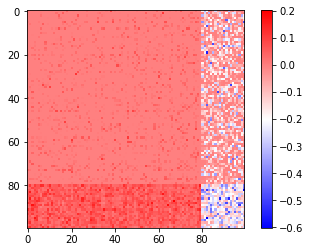

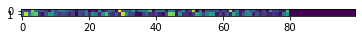

In [43]:
# weights = model.get_weights()
# W_rec = weights['W_rec']
# plt.imshow(W_rec, cmap='bwr', interpolation='nearest')
# # plt.imshow(W_rec)

# plt.colorbar()
# plt.show()

# W_in = weights['W_in']
# plt.imshow(W_in, cmap='bwr', interpolation='nearest')
# plt.imshow(W_in)

# W_out = weights['W_out']
# plt.imshow(W_out, cmap='bwr', interpolation='nearest')
# plt.imshow(W_out)

# # plt.colorbar()
# # plt.show()

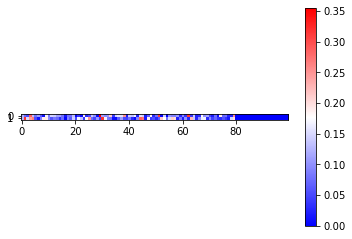

In [44]:
W_out = weights['W_out']
plt.imshow(W_out, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.show()

# Test 5000 trials

In [29]:
trials =5000
batches = int(np.ceil(trials / N_batch))


rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

green_side = np.zeros(trials) 
coherence = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)

correct_side = np.zeros(trials)

decision = np.zeros(trials)
rt = np.zeros(trials)


In [30]:
for b in tqdm(range(batches)):
    [x, y, mask, params] = task.get_trial_batch()
    outputs, states, inputs = model.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    


    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        checker_onset[index] = params[i]["checker_onset"]
        
        correct_side[index] = params[i]["coherence"] < 0 
        
        
        ############ calculate RT and decision made 
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        
        # decision here: left: -1; right: 1; time out: 0
#         if (np.sum(outputs[i,:,0] > 0.7) != 0):
#             decision[index] = 0
#             temp = np.where(outputs[i,:,0] > 0.7)
#             rt[index] = temp[0][0]*task.dt - target_onset[index] - checker_onset[index] 
#         elif (np.sum(outputs[i,:,1] > 0.7) != 0):
#             decision[index] = 1
#             temp = np.where(outputs[i,:,1] > 0.7)
#             rt[index] = temp[0][0]*task.dt - target_onset[index] - checker_onset[index]             

#         else:
#             decision[index] = 2
#             rt[index] = T - target_onset[index] - checker_onset[index]

        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index] 


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


In [22]:
thr

(array([ 0,  1,  2,  3,  4,  4,  5,  5,  5,  6,  6,  7,  7,  7,  7,  8,  8,
         9, 10, 11, 12, 12, 13, 14, 14, 15, 15, 16, 16, 16, 17, 17, 18, 19,
        20, 20, 21, 22, 23, 24, 24, 25, 25, 25, 26, 27, 27, 28, 29, 29, 30,
        31, 33, 33, 33, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47,
        48, 49]),
 array([101, 126,  99,  83, 130, 131, 161, 162, 163, 168, 169,  99, 100,
        101, 102, 270, 271, 154, 306,  46, 122, 123, 101, 171, 172, 152,
        153, 198, 199, 200, 187, 188, 160, 156, 185, 186, 150, 115,  77,
        170, 171, 137, 138, 141, 186, 151, 152, 292, 154, 155, 171, 289,
        122, 123, 124, 125, 156, 122, 104, 396,  70, 292, 119, 148, 138,
        363, 242, 104, 132, 112]),
 array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 0]))

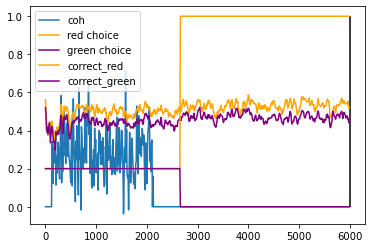

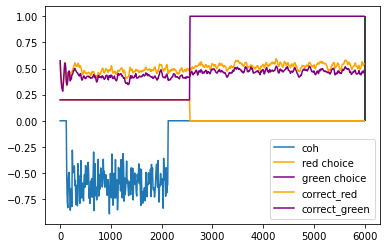

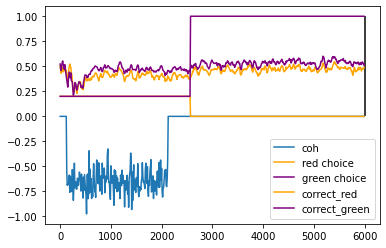

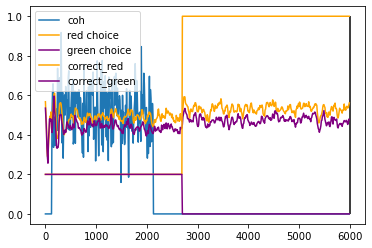

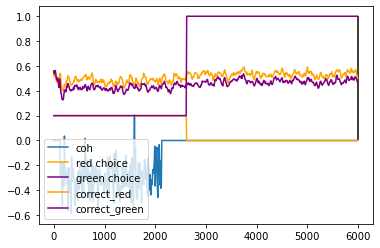

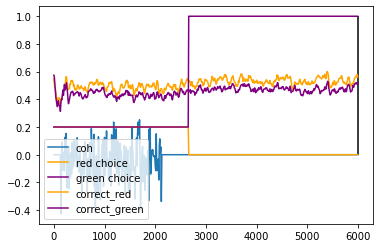

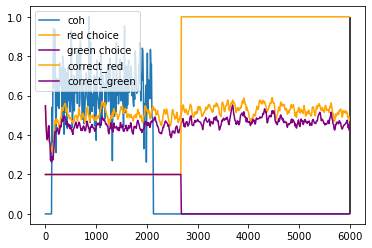

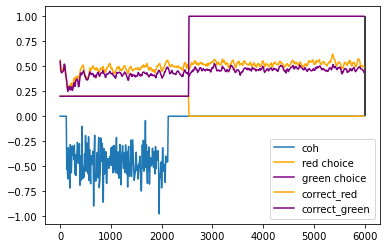

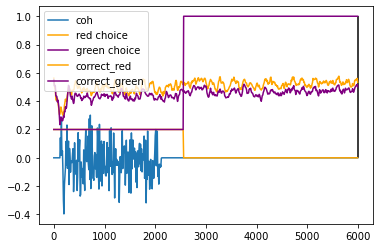

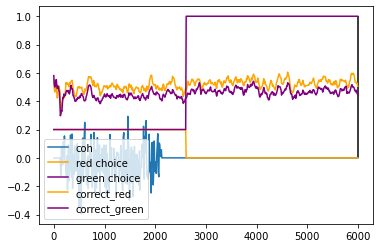

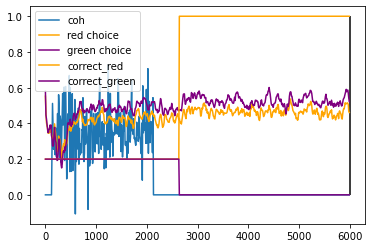

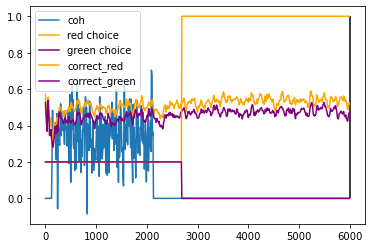

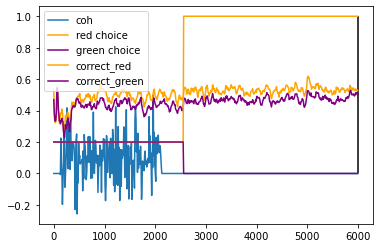

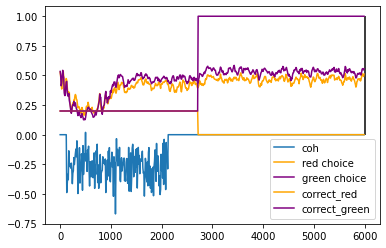

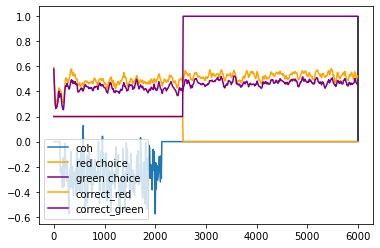

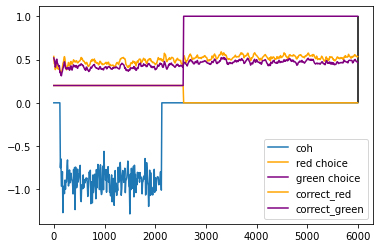

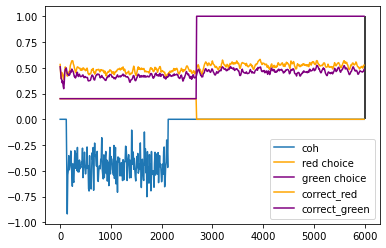

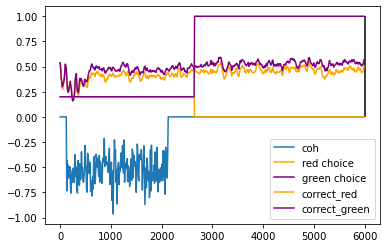

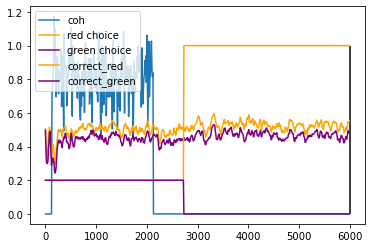

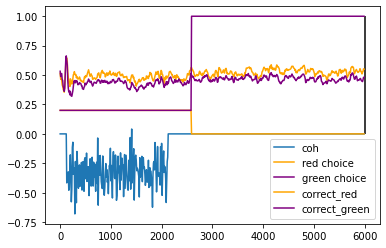

In [31]:
# plot example trials
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(0,20):
    plt.figure()
#     plt.plot(np.arange(0, T, 10), inputs[i, :, 0], label = 'config')
    plt.plot(np.arange(0, T, 10), inputs[i, :, 1], label = 'coh')

    plt.plot(np.arange(0, T, 10), outputs[i, :, 0], label = 'red choice', color = 'orange')
    plt.plot(np.arange(0, T, 10), outputs[i, :, 1], label = 'green choice', color = 'purple')    
    plt.plot(np.arange(0, T, 10), y[i, :, 0], label = 'correct_red', color = 'orange')
    plt.plot(np.arange(0, T, 10), y[i, :, 1], label = 'correct_green', color = 'purple')
    plt.legend()
    
    
#     plt.vlines(onsets[i], 0, 1, color = 'k')
    plt.vlines(onsets[i] + rts[i], 0, 1, color = 'k')
#     plt.figure()
#     plt.plot(np.arange(0, T, 10), g[i])

In [1]:

checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           # the real coherence based on left and right (positive: left evidence dominant
                           # negative: right evidence dominant)
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'correct_side' : correct_side,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int),
                          'green_side' : green_side})



print("Overall Accuracy: " + str(np.sum(checker_df["correct_decision"])/len(checker_df)))
print("Negative RT trials ratio: ", end = "")
print(np.sum(checker_df["decision_time"] < 0)/len(checker_df))



NameError: name 'pd' is not defined

In [2]:
# checker_df


# only the behavior results dataframe has this
# chosen color: 1 (red); 0 (green)
# all other setup has 
# chosen color: 1 (red); -1 (green)

chosen_color = np.zeros([len(checker_df),1])
for i in range(len(checker_df)):
    if(checker_df.green_side[i] == 0 and checker_df.decision[i] == 0):
        chosen_color[i] = 0
    if(checker_df.green_side[i] == 0 and checker_df.decision[i] == 1):
        chosen_color[i] = 1        
    if(checker_df.green_side[i] == 1 and checker_df.decision[i] == 1):  
        chosen_color[i] = 0        
    if(checker_df.green_side[i] == 1 and checker_df.decision[i] == 0):        
        chosen_color[i] = 1        
        
checker_df["chosen_color"] = chosen_color

checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()


#######################
## summary result save path

resultPath = "./checkerCFD3Test.csv"
checker_df.to_csv(resultPath)

NameError: name 'np' is not defined

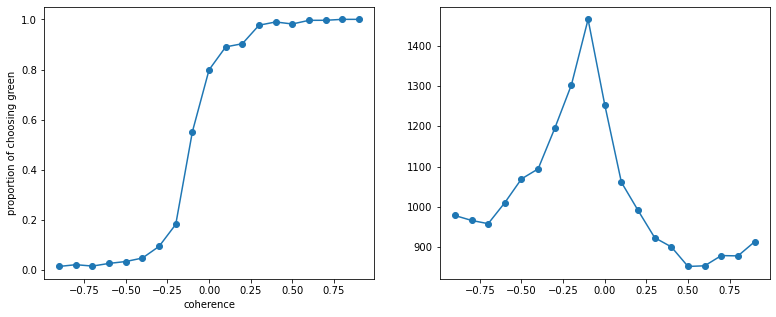

In [62]:
# psychrometric curve 
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], checker_mean['chosen_color'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['chosen_color'])
plt.xlabel("coherence")
plt.ylabel("proportion of choosing green")
plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])



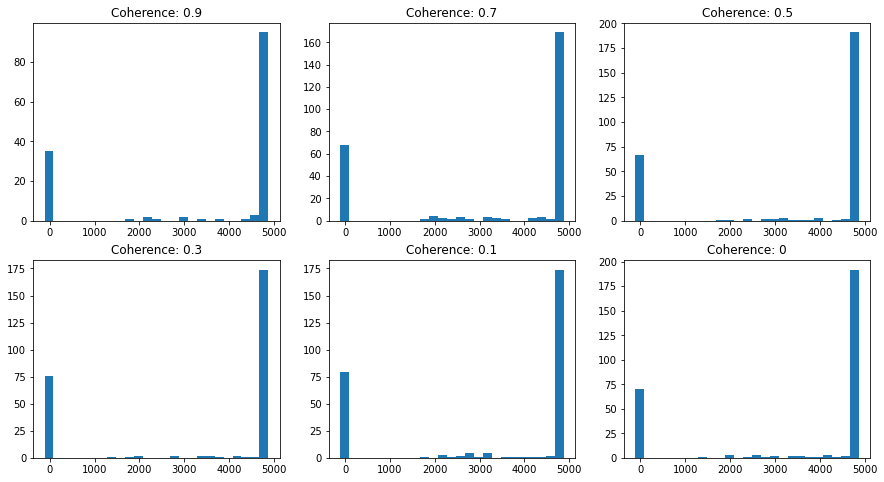

In [27]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 25)
    plt.title("Coherence: " + str(i))
    idx = idx + 1

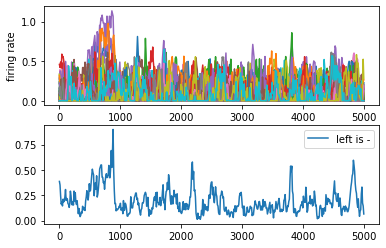

In [24]:
trial_num = 50
plt.figure()
plt.subplot(211)
_ = plt.plot(np.arange(0, T, dt), rnn_state[trial_num,:,:])
plt.xlabel("time step (10ms)")
plt.ylabel("firing rate")
plt.subplot(212)
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,0], label = "left is -")
plt.legend()

In [25]:
# transpose the data and save as .mat file for analysis on matlab
temp = np.transpose(rnn_state, (2,1,0))
from scipy.io import savemat
mdic = {'temp': temp}
savemat("temp.mat", mdic)

In [26]:
model.destruct()